In [1]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd



In [4]:
imgs_path = "C:\\ut-zap50k-images-square"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5  # number of most similar images to retrieve




In [5]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

In [6]:
processed_files = []
importedImages = []
batch_size = 32  
imgs_features_list = []  # List to accumulate features for each batch

for type_folder in os.listdir(imgs_path):
    type_path = os.path.join(imgs_path, type_folder)

    for model_folder in os.listdir(type_path):
        model_path = os.path.join(type_path, model_folder)

        for brand_folder in os.listdir(model_path):
            brand_path = os.path.join(model_path, brand_folder)

            for img_file in os.listdir(brand_path):
                filename = os.path.join(brand_path, img_file)
                original = load_img(filename, target_size=(224, 224))
                numpy_image = img_to_array(original)
                image_batch = np.expand_dims(numpy_image, axis=0)
                importedImages.append(image_batch)

                # Process images in batches
                if len(importedImages) == batch_size:
                    batch = np.vstack(importedImages)
                    processed_batch = preprocess_input(batch.copy())
                    
                    
                    # Extract and accumulate features for the current batch
                    batch_features = feat_extractor.predict(processed_batch)
                    imgs_features_list.append(batch_features)

                    importedImages = []

# Process the remaining images in the last batch
if importedImages:
    batch = np.vstack(importedImages)
    processed_batch = preprocess_input(batch.copy())
    
    
    # Extract and accumulate features for the last batch
    batch_features = feat_extractor.predict(processed_batch)
    imgs_features_list.append(batch_features)

    importedImages = []

# Concatenate features for all batches
imgs_features = np.vstack(imgs_features_list)
np.save('imgs_features.npy', imgs_features)
loaded_features = np.load('imgs_features.npy')
print("Features successfully extracted!")



1/1 [==============================] - 2s 2s/step
Features successfully extracted!


In [16]:
loaded_features.shape

(50066, 4096)

In [22]:
import pandas as pd
import numpy as np
import os

# Initialize a list to store file names
file_paths = []
  
for type_folder in os.listdir(imgs_path):
    for model_folder in os.listdir(os.path.join(imgs_path, type_folder)):
        for brand_folder in os.listdir(os.path.join(imgs_path, type_folder, model_folder)):
            for file_name in os.listdir(os.path.join(imgs_path, type_folder, model_folder, brand_folder)):
                file_path = os.path.join(imgs_path, type_folder, model_folder, brand_folder, file_name)
                file_paths.append(file_path.replace('/', '\\\\'))  # Replace forward slashes with double backward slashes

# Create a DataFrame with full file paths as index and loaded_features as columns
loaded_features_df = pd.DataFrame(loaded_features, index=file_paths)

# Display the DataFrame
print(loaded_features_df)



                                                    0     1         2     \
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...   0.0   0.0  1.481915   
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...   0.0   0.0  0.000000   
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...   0.0   0.0  0.000000   
C:\ut-zap50k-images-square\Boots\Ankle\adidas\8...   0.0   0.0  1.713786   
C:\ut-zap50k-images-square\Boots\Ankle\adidas\8...   0.0   0.0  0.000000   
...                                                  ...   ...       ...   
C:\ut-zap50k-images-square\Slippers\Slipper Hee...   0.0   0.0  0.320422   
C:\ut-zap50k-images-square\Slippers\Slipper Hee...   0.0   0.0  1.824883   
C:\ut-zap50k-images-square\Slippers\Slipper Hee...   0.0   0.0  0.136090   
C:\ut-zap50k-images-square\Slippers\Slipper Hee...   0.0   0.0  1.000569   
C:\ut-zap50k-images-square\Slippers\Slipper Hee...   0.0   0.0  0.813010   

                                                    3     4         5     \
C:\ut-zap50

In [23]:
loaded_features_df.shape

(50066, 4096)

In [37]:
from sklearn.metrics import jaccard_score

# Example: You need to replace this with the actual path of your query image
query_image_path = "C:\\ut-zap50k-images-square\\Boots\\Mid-Calf\\adidas by Stella McCartney\\8003655.139.jpg"

# Example: Retrieve features for the query image
query_image_features = loaded_features_df.loc[query_image_path].values.reshape(1, -1)

# Example: Set a threshold (you may need to adjust this based on your features)
threshold = 0.5
binary_query_features = (query_image_features > threshold).astype(int)

# Example: Apply thresholding to all features in the DataFrame
binary_loaded_features_df = (loaded_features_df > threshold).astype(int)

# Example: Calculate Jaccard similarities
jaccard_similarities = binary_loaded_features_df.apply(lambda x: jaccard_score(binary_query_features.flatten(), x, pos_label=1), axis=1)

# Create a DataFrame with Jaccard similarities
jaccard_similarities_df = pd.DataFrame({"Jaccard Similarity": jaccard_similarities}, index=loaded_features_df.index)

# Retrieve top similar-looking images
similar_images = jaccard_similarities_df.sort_values(by="Jaccard Similarity", ascending=False).head(10).index.tolist()[1:]

# Retrieve the actual image data for the top similar images
similar_images_data = loaded_features_df.loc[similar_images]

# Print or use the top similar images data
print(similar_images_data)



                                                    0         1         2     \
C:\ut-zap50k-images-square\Boots\Mid-Calf\Easy ...   0.0  0.000000  0.233150   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Mount...   0.0  0.000000  0.000000   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Sprin...   0.0  0.000000  0.084381   
C:\ut-zap50k-images-square\Boots\Ankle\The Nort...   0.0  0.000000  0.775545   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Easy ...   0.0  0.000000  0.000000   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Sprin...   0.0  0.000000  0.131609   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Pampi...   0.0  0.000000  0.834809   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Mount...   0.0  0.203815  0.563467   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Primi...   0.0  0.000000  0.967721   

                                                    3     4         5     \
C:\ut-zap50k-images-square\Boots\Mid-Calf\Easy ...   0.0   0.0  0.000000   
C:\ut-zap50k-images-square\Boots\Mid-Calf\Mount

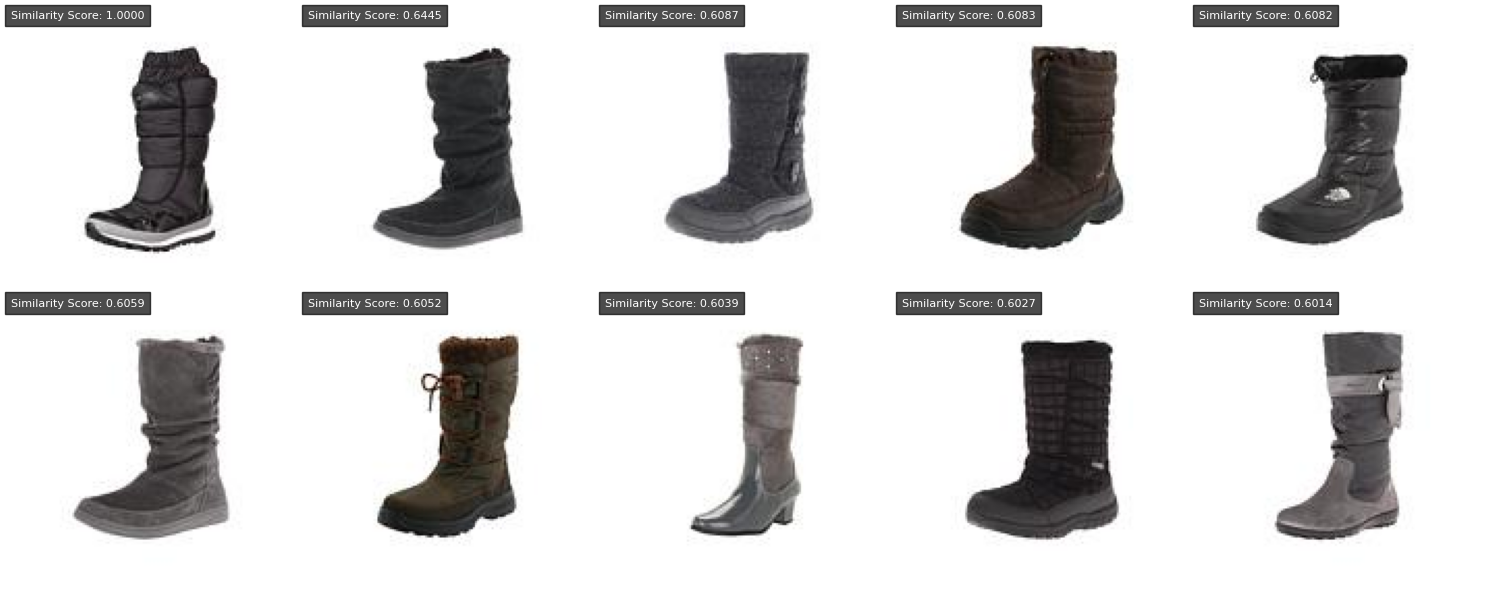

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Assuming jaccard_similarities_df is your DataFrame with Jaccard similarity scores
similar_images = jaccard_similarities_df.sort_values(by="Jaccard Similarity", ascending=False).head(10)

# Retrieve top 10 similar image file paths and scores
similar_image_paths = similar_images.index.tolist()
similar_image_scores = similar_images["Jaccard Similarity"].tolist()

# Calculate the number of rows and columns for the grid
num_images = len(similar_image_paths)
num_rows = math.ceil(num_images / 5)
num_cols = min(num_images, 5)

# Display top 10 similar images with scores in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (image_path, similarity_score) in enumerate(zip(similar_image_paths, similar_image_scores)):
    img = mpimg.imread(image_path)
    
    # Calculate the row and column index for the subplot
    row_idx = i // 5
    col_idx = i % 5
    
    # Display image
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].axis('off')  # Turn off axis labels
    
    # Display similarity score as text on the image
    axes[row_idx, col_idx].text(0, 0, f"Similarity Score: {similarity_score:.4f}", color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [40]:
import numpy as np

# Example: You need to replace this with the actual path of your query image
query_image_path = "C:\\ut-zap50k-images-square\\Boots\\Mid-Calf\\adidas by Stella McCartney\\8003655.139.jpg"

# Example: Retrieve features for the query image
query_image_features = loaded_features_df.loc[query_image_path].values

# Calculate Euclidean distance with all other images
euclidean_distances = np.linalg.norm(loaded_features_df.values - query_image_features, axis=1)

# Create a DataFrame with Euclidean distances
euclidean_distances_df = pd.DataFrame({"Euclidean Distance": euclidean_distances}, index=loaded_features_df.index)

# Display the DataFrame or use the distances as needed
print(euclidean_distances_df)


                                                    Euclidean Distance
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...           66.818451
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...           84.204338
C:\ut-zap50k-images-square\Boots\Ankle\A. Testo...           67.885162
C:\ut-zap50k-images-square\Boots\Ankle\adidas\8...           70.473709
C:\ut-zap50k-images-square\Boots\Ankle\adidas\8...           62.872890
...                                                                ...
C:\ut-zap50k-images-square\Slippers\Slipper Hee...           89.732964
C:\ut-zap50k-images-square\Slippers\Slipper Hee...           85.862045
C:\ut-zap50k-images-square\Slippers\Slipper Hee...           84.329979
C:\ut-zap50k-images-square\Slippers\Slipper Hee...          110.703857
C:\ut-zap50k-images-square\Slippers\Slipper Hee...          112.840065

[50066 rows x 1 columns]


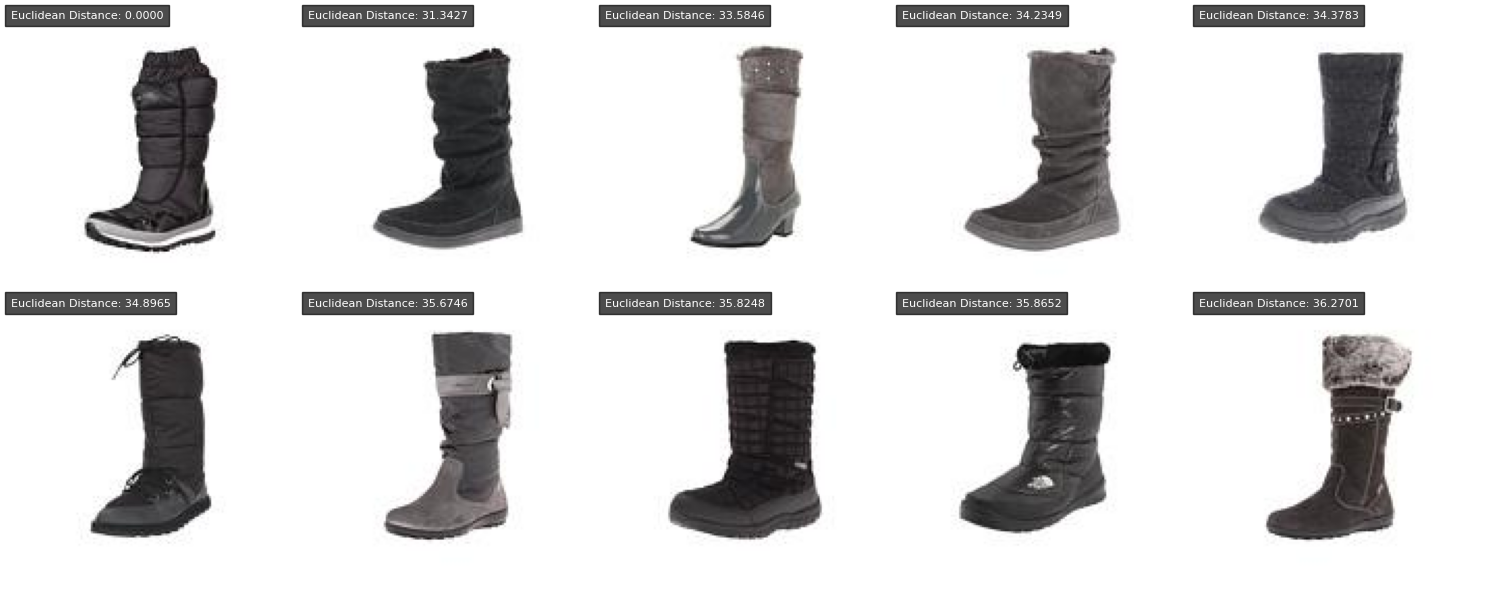

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Assuming euclidean_distances_df is your DataFrame with Euclidean distances
similar_images = euclidean_distances_df.sort_values(by="Euclidean Distance").head(10)

# Retrieve similar image file paths and distances
similar_image_paths = similar_images.index.tolist()
similar_image_distances = similar_images["Euclidean Distance"].tolist()

# Calculate the number of rows and columns for the grid
num_images = len(similar_image_paths)
num_rows = math.ceil(num_images / 5)
num_cols = min(num_images, 5)

# Display similar images with distances in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (image_path, distance) in enumerate(zip(similar_image_paths, similar_image_distances)):
    img = mpimg.imread(image_path)
    
    # Calculate the row and column index for the subplot
    row_idx = i // 5
    col_idx = i % 5
    
    # Display image
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].axis('off')  # Turn off axis labels
    
    # Display Euclidean distance as text on the image
    axes[row_idx, col_idx].text(0, 0, f"Euclidean Distance: {distance:.4f}", color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os

# Specify the path to your images directory
imgs_path = "C:\\Users\\arava\\OneDrive\\Documents\\Purdue\\ut-zap50k-images-square"

# Initialize a list to store file paths
file_paths = []

# Loop through the image directory and collect all file paths
for type_folder in os.listdir(imgs_path):
    for model_folder in os.listdir(os.path.join(imgs_path, type_folder)):
        for brand_folder in os.listdir(os.path.join(imgs_path, type_folder, model_folder)):
            for file_name in os.listdir(os.path.join(imgs_path, type_folder, model_folder, brand_folder)):
                file_path = os.path.join(imgs_path, type_folder, model_folder, brand_folder, file_name)
                file_paths.append(file_path.replace('/', '\\\\'))  # Replace forward slashes with double backward slashes

# Compute cosine similarities between all images
cos_similarities = cosine_similarity(imgs_features)

# Store the results into a pandas dataframe with file paths as indices
cos_similarities_df = pd.DataFrame(cos_similarities, columns=file_paths, index=file_paths)

# Print the dataframe
print(cos_similarities_df)


                                                    C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\7965307.5291.jpg  \
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap...                                           1.000000                                                          
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap...                                           0.743547                                                          
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap...                                           0.738789                                                          
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap...                                           0.622616                                                          
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap...                                           0.487979                                                          
...                                     

In [28]:
cos_similarities_df.head()

,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\7965307.5291.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\7999255.363731.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\8000978.364150.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas\8030969.3.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas\8030970.107722.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas Kids\8070145.388249.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas Kids\8070146.388250.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas Originals\8027274.372160.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas Originals\8027274.372161.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas Originals\8027310.115329.jpg,...,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.14.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.172.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.385.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.46867.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.552.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.570.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\105772.72.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\Daniel Green\117456.7907.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\L.B. Evans\7590239.255.jpg,C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Slippers\Slipper Heels\L.B. Evans\7590239.72.jpg
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\7965307.5291.jpg,1.000000,0.743547,0.738789,0.622616,0.487979,0.519110,0.524363,0.559748,0.703893,0.627947,...,0.385272,0.500362,0.549920,0.440098,0.611301,0.533541,0.662886,0.439643,0.555858,0.609309
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\7999255.363731.jpg,0.743547,1.000000,0.761096,0.632911,0.535673,0.461429,0.451807,0.563824,0.750662,0.737354,...,0.466209,0.573528,0.630723,0.481309,0.686896,0.652489,0.722264,0.498699,0.629732,0.693559
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\A. Testoni\8000978.364150.jpg,0.738789,0.761096,1.000000,0.562999,0.486096,0.367349,0.380291,0.426928,0.602961,0.619362,...,0.379496,0.471132,0.503173,0.466056,0.555498,0.528030,0.593564,0.477319,0.522157,0.569028
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas\8030969.3.jpg,0.622616,0.632911,0.562999,1.000000,0.650395,0.620816,0.603493,0.680977,0.823488,0.738529,...,0.379254,0.422529,0.453223,0.390012,0.496617,0.483665,0.516635,0.391820,0.417861,0.467177
C:\Users\arava\OneDrive\Documents\Purdue\ut-zap50k-images-square\Boots\Ankle\adidas\8030970.107722.jpg,0.487979,0.535673,0.486096,0.650395,1.000000,0.520825,0.510861,0.623982,0.693852,0.688152,...,0.594748,0.582299,0.565818,0.535349,0.559742,0.619927,0.558323,0.544275,0.456810,0.480212


-----------------------------------------------------------------------
Original product:


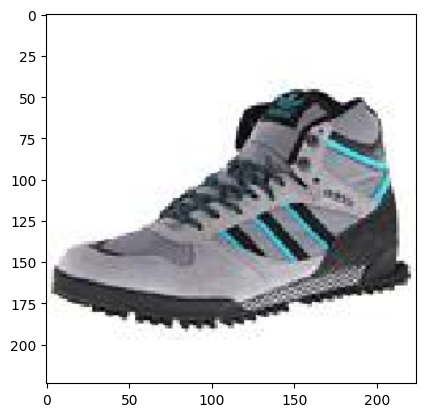

-----------------------------------------------------------------------
Most similar products:


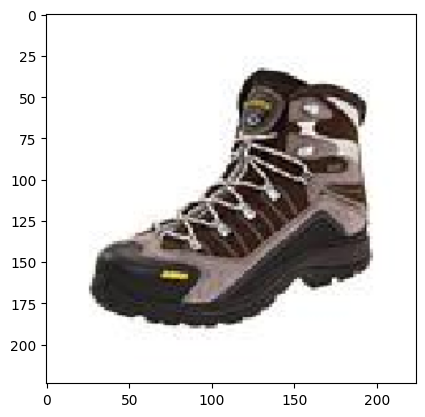

Similarity score: 0.819651


C:\Users\arava\AppData\Local\Temp\ipykernel_14752\356025463.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Similarity score:", closest_imgs_scores[i])


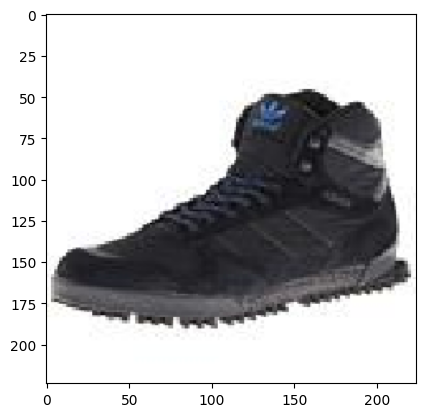

Similarity score: 0.80965126


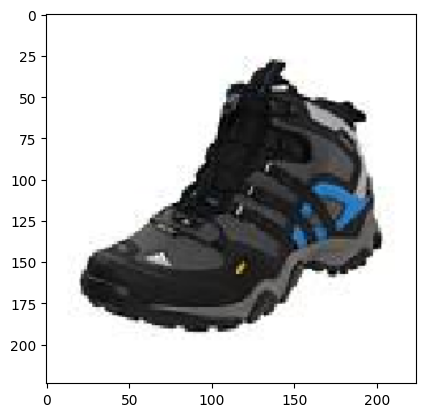

Similarity score: 0.7861597


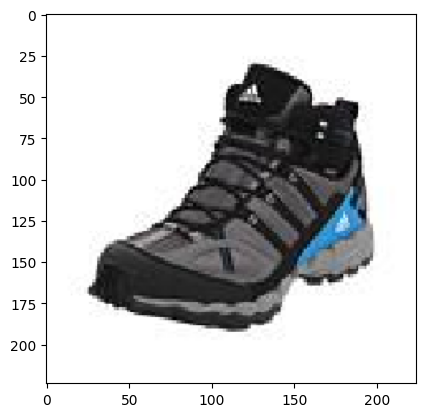

Similarity score: 0.7831464


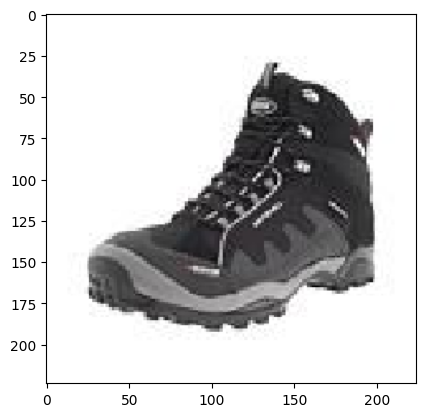

Similarity score: 0.77981937


In [24]:
# Function to retrieve the most similar products for a given one
def retrieve_most_similar_products(given_img):
    print("-----------------------------------------------------------------------")
    print("Original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("Similarity score:", closest_imgs_scores[i])

# Example: Retrieve similar products for a given image
given_image_path = "C:\\Users\\arava\\OneDrive\\Documents\\Purdue\\ut-zap50k-images-square\\Boots\\Ankle\\adidas Originals\\8027274.372160.jpg"
retrieve_most_similar_products(given_image_path)

-----------------------------------------------------------------------
Original product:


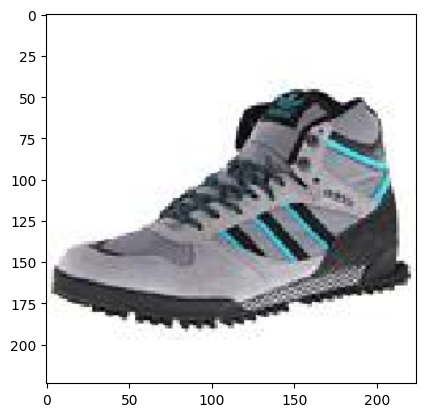

-----------------------------------------------------------------------
Most similar products:


C:\Users\arava\AppData\Local\Temp\ipykernel_14752\3371567581.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  similarity_score = closest_imgs_scores[i]


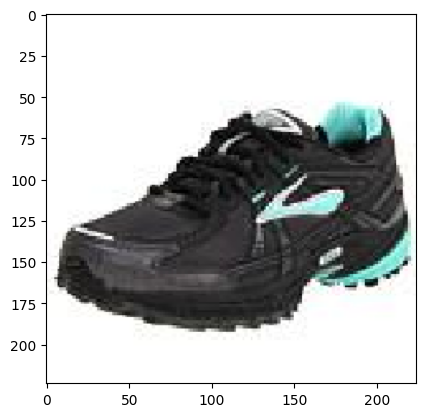

Similarity score: 0.86299


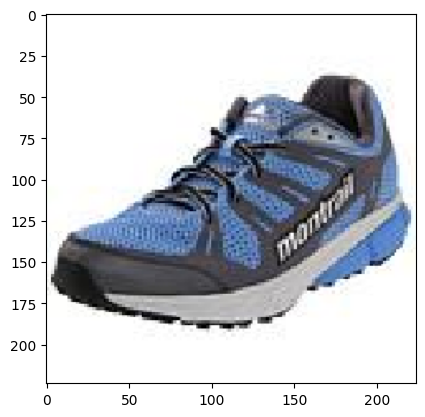

Similarity score: 0.85345507


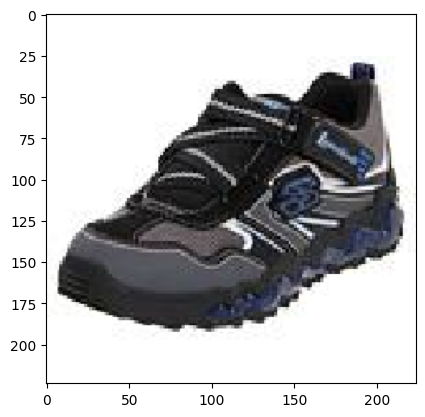

Similarity score: 0.8514577


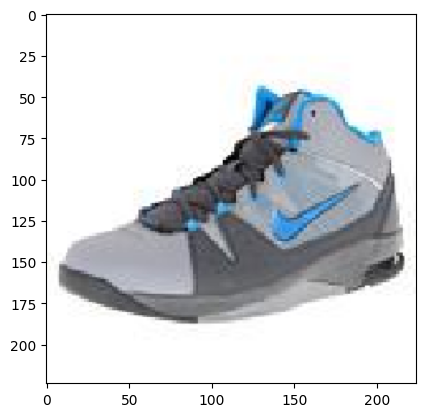

Similarity score: 0.85105085


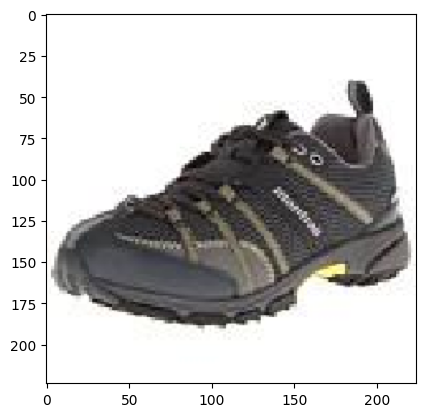

Similarity score: 0.85046196


In [29]:
# Function to retrieve the most similar products for a given one
def retrieve_most_similar_products(given_img, nb_closest_images=5):
    print("-----------------------------------------------------------------------")
    print("Original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(len(closest_imgs)):
        similar_img_path = closest_imgs[i]
        similarity_score = closest_imgs_scores[i]

        # Load and display the similar product
        similar_img = load_img(similar_img_path, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(similar_img)
        plt.show()

        print("Similarity score:", similarity_score)

# Example: Retrieve similar products for a given image
given_image_path = "C:\\Users\\arava\\OneDrive\\Documents\\Purdue\\ut-zap50k-images-square\\Boots\\Ankle\\adidas Originals\\8027274.372160.jpg"
retrieve_most_similar_products(given_image_path)


-----------------------------------------------------------------------
Original product:


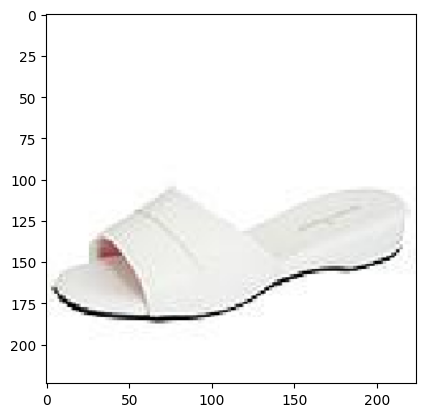

-----------------------------------------------------------------------
Most similar products:


C:\Users\arava\AppData\Local\Temp\ipykernel_14752\466266138.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  similarity_score = closest_imgs_scores[i]


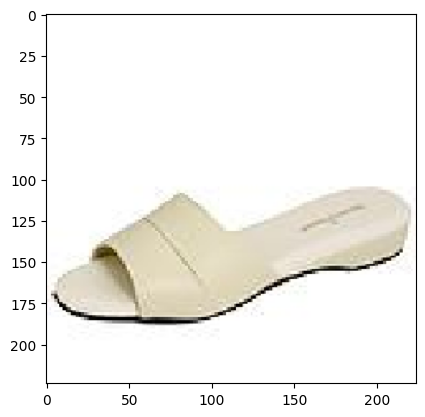

Similarity score: 0.9107975


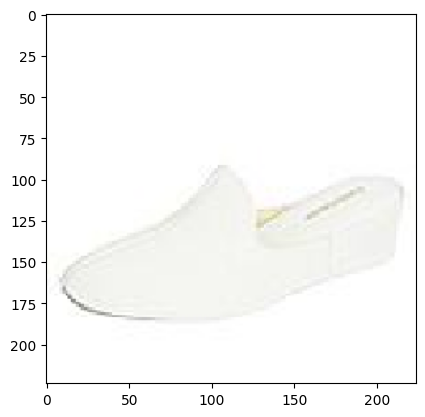

Similarity score: 0.8415017


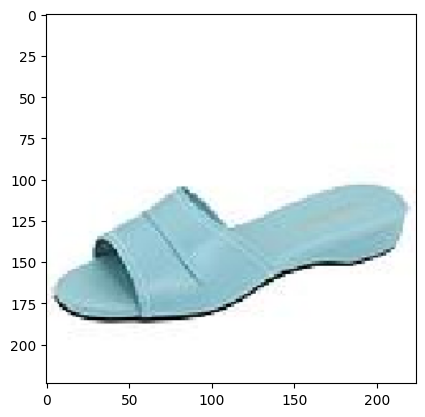

Similarity score: 0.81760764


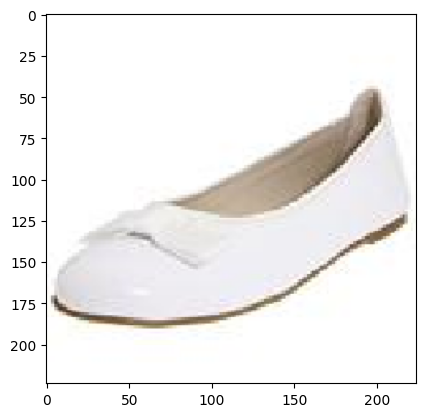

Similarity score: 0.8005481


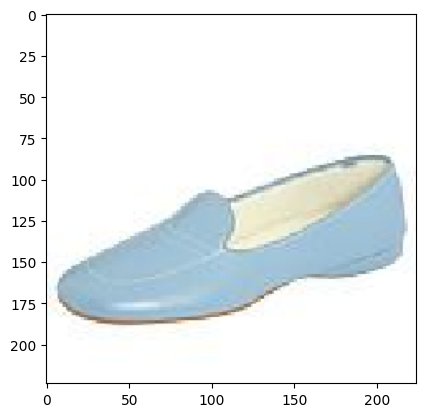

Similarity score: 0.7913707


In [30]:
# Function to retrieve the most similar products for a given one
def retrieve_most_similar_products(given_img, nb_closest_images=5):
    print("-----------------------------------------------------------------------")
    print("Original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(len(closest_imgs)):
        similar_img_path = closest_imgs[i]
        similarity_score = closest_imgs_scores[i]

        # Load and display the similar product
        similar_img = load_img(similar_img_path, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(similar_img)
        plt.show()

        print("Similarity score:", similarity_score)

# Example: Retrieve similar products for a given image
given_image_path = "C:\\Users\\arava\\OneDrive\\Documents\\Purdue\\ut-zap50k-images-square\\Slippers\\Slipper Heels\\Daniel Green\\105772.14.jpg"
retrieve_most_similar_products(given_image_path)

-----------------------------------------------------------------------
Original product:


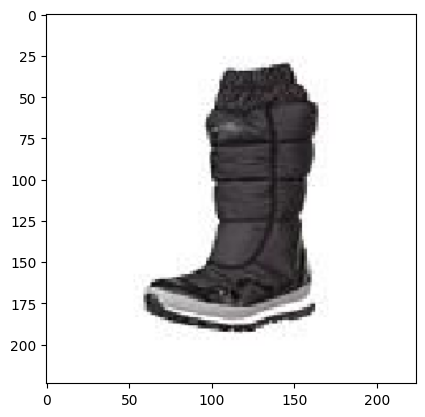

-----------------------------------------------------------------------
Most similar products:


C:\Users\arava\AppData\Local\Temp\ipykernel_14752\119690666.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  similarity_score = closest_imgs_scores[i]


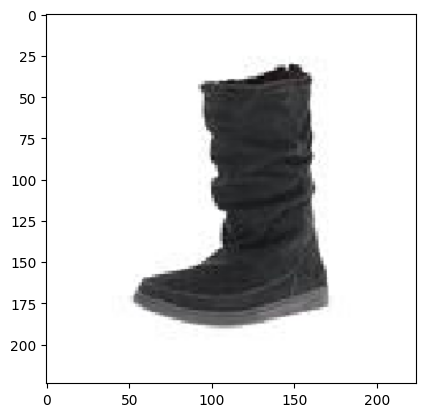

Similarity score: 0.8844114


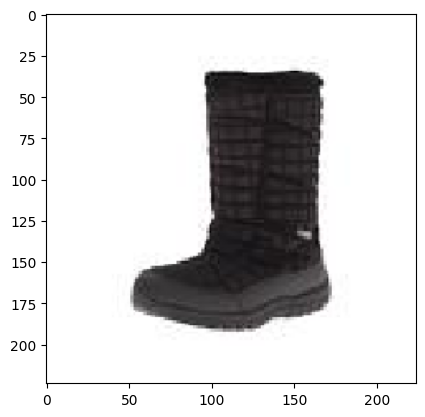

Similarity score: 0.8611735


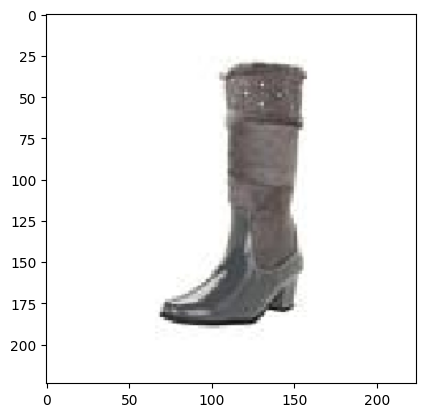

Similarity score: 0.86110526


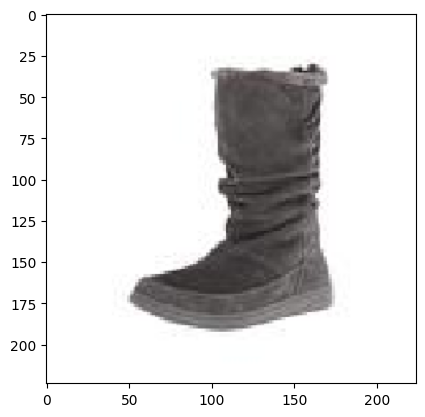

Similarity score: 0.8602848


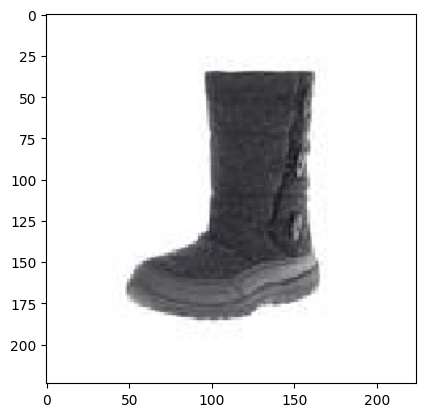

Similarity score: 0.8576843


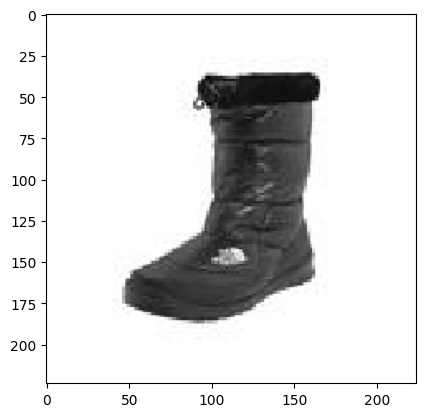

Similarity score: 0.8518384


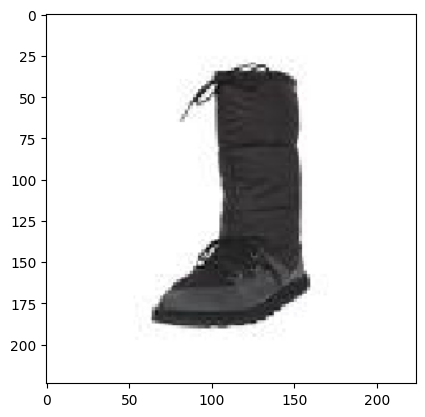

Similarity score: 0.8515393


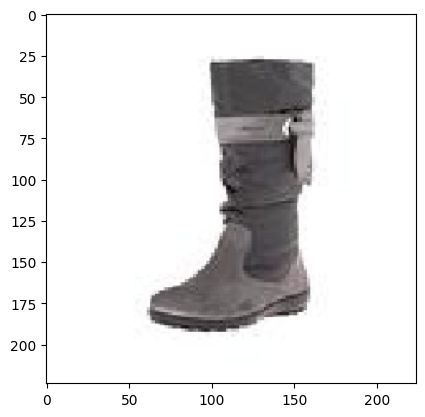

Similarity score: 0.84833443


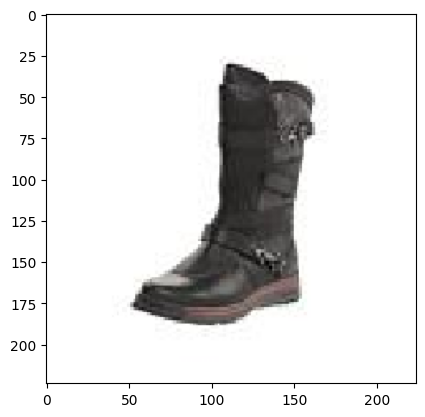

Similarity score: 0.8452412


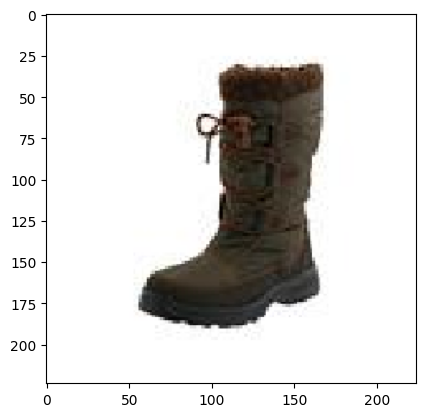

Similarity score: 0.8411783


In [31]:
# Function to retrieve the most similar products for a given one
def retrieve_most_similar_products(given_img, nb_closest_images=10):
    print("-----------------------------------------------------------------------")
    print("Original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images + 1]

    for i in range(len(closest_imgs)):
        similar_img_path = closest_imgs[i]
        similarity_score = closest_imgs_scores[i]

        # Load and display the similar product
        similar_img = load_img(similar_img_path, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(similar_img)
        plt.show()

        print("Similarity score:", similarity_score)

# Example: Retrieve similar products for a given image
given_image_path = "C:\\Users\\arava\\OneDrive\\Documents\\Purdue\\ut-zap50k-images-square\\Boots\\Mid-Calf\\adidas by Stella McCartney\\8003655.139.jpg"
retrieve_most_similar_products(given_image_path)